In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D ,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
from imageio import imread

import gc
from copy import deepcopy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from keras import initializers
from keras import regularizers
from sklearn.model_selection import TimeSeriesSplit
from keras.models import load_model  

%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


加载  预处理数据

In [2]:
# 交通矩阵为 matrix_length*matrix_length
matrix_length = 32

matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [3]:
def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = week_delta_list+minute_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array

In [4]:
week_history_num = 1
minute_history_num = 1

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

# train_array为(16704, 32, 32, 3)，16704个矩阵，32*32采集点，3从上到下为当前时间，上一周，上一15min
train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.2, random_state=42)
# X_train, X_val = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False) # 不shuffle可用于查看数据正确性

[Timedelta('7 days 00:00:00'), Timedelta('0 days 00:15:00')]
(16704, 32, 32, 3)


In [5]:
X_train.shape, X_test.shape

((13363, 32, 32, 3), (3341, 32, 32, 3))

In [6]:
MAX_BATCH_SIZE = 32
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
test_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, test_steps

(104, 26)

In [7]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        true_volume, history_volume = batch_matrix[:, :, :, :1], batch_matrix[:, :, :, 1:]
        batch_i+=1

        yield true_volume, history_volume

In [8]:
import math

def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

模型

In [9]:
def BatchActivate(x, bn=True):
    if bn:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [10]:
size = (3, 3)
g_filters_base = 32
DropoutRatio = 0.5
learn_rate = 0.005

channels = 3
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channels-1)

kernel_init = 'glorot_uniform'
bias_init = 'zeros'
kernel_regul = regularizers.l2(1.5)
activity_regul = regularizers.l2(1.5)

# Generator
# def build_generator():
    
#     input_matrix = Input(shape=history_volume_shape)
#     # 32 -> 16
#     conv1 = Conv2D(g_filters_base * 1, size, strides=1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(input_matrix)
#     conv1 = BatchActivate(conv1, False)
# #     conv1 = residual_block(conv1,g_filters_base * 1)
# #     conv1 = residual_block(conv1,g_filters_base * 1, True)
#     pool1 = AveragePooling2D((2, 2))(conv1)
#     pool1 = Dropout(DropoutRatio/2)(pool1)

#     # 16 -> 8
#     conv2 = Conv2D(g_filters_base * 2, size, activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(pool1)
#     conv2 = BatchActivate(conv2)
# #     conv2 = residual_block(conv2,g_filters_base * 2)
# #     conv2 = residual_block(conv2,g_filters_base * 2, True)
#     pool2 = AveragePooling2D((2, 2))(conv2)
#     pool2 = Dropout(DropoutRatio)(pool2)

#     # 8 -> 4
#     conv3 = Conv2D(g_filters_base * 4, size, activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(pool2)
#     conv3 = BatchActivate(conv3)
# #     conv3 = residual_block(conv3,g_filters_base * 4)
# #     conv3 = residual_block(conv3,g_filters_base * 4, True)
#     pool3 = AveragePooling2D((2, 2))(conv3)
#     pool3 = Dropout(DropoutRatio)(pool3)

#     # Middle
#     convm = Conv2D(g_filters_base * 8, size, activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(pool3)
#     convm = BatchActivate(convm)
# #     convm = residual_block(convm,g_filters_base * 16)
# #     convm = residual_block(convm,g_filters_base * 16, True)
    
#     # 4 -> 8
#     deconv3 = Conv2DTranspose(g_filters_base * 4, (3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(convm)
#     uconv3 = concatenate([deconv3, conv3])    
#     uconv3 = Dropout(DropoutRatio)(uconv3)
    
#     uconv3 = Conv2D(g_filters_base * 4, (3, 3), activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv3)
#     uconv3 = BatchActivate(uconv3)
# #     uconv3 = residual_block(uconv3,g_filters_base * 4)
# #     uconv3 = residual_block(uconv3,g_filters_base * 4, True)

#     # 8 -> 16
#     deconv2 = Conv2DTranspose(g_filters_base * 2, size, strides=(2, 2), padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv3)
#     uconv2 = concatenate([deconv2, conv2])
        
#     uconv2 = Dropout(DropoutRatio)(uconv2)
#     uconv2 = Conv2D(g_filters_base * 2, (3, 3), activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv2)
#     uconv2 = BatchActivate(uconv2)
# #     uconv2 = residual_block(uconv2,g_filters_base * 2)
# #     uconv2 = residual_block(uconv2,g_filters_base * 2, True)
    
#     # 16 -> 32
#     deconv1 = Conv2DTranspose(g_filters_base * 1, (3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv2)
#     uconv1 = concatenate([deconv1, conv1])
    
#     uconv1 = Dropout(DropoutRatio)(uconv1)
#     uconv1 = Conv2D(g_filters_base * 1, (3, 3), activation=None, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv1)
#     uconv1 = BatchActivate(uconv1)
# #     uconv1 = residual_block(uconv1,g_filters_base * 1)
# #     uconv1 = residual_block(uconv1,g_filters_base * 1, True)
    
#     uconv1 = Dropout(DropoutRatio/2)(uconv1)
#     #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
#     output = Conv2D(1, (1,1), padding="same", activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(uconv1)
    
#     model = Model(input_matrix, output)
#     model.compile(loss='mse', optimizer=Adam(lr=0.004), metrics=['mse'])
    
#     return model


In [11]:
def build_generator():      

    # INPUTS
    input_matrix = Input(shape=history_volume_shape)
    # kernel_init = initializers.he_normal()
    # bias_init = initializers.he_normal()
    kernel_init = 'glorot_uniform'
    bias_init = 'zeros'

    # kernel_init = initializers.he_uniform()
    # bias_init = initializers.he_uniform()
    kernel_regul = regularizers.l2(1)
    activity_regul = regularizers.l2(1)

    # ENCODER
    def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
        # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
        conv = Conv2D(filters, (kernel_size, kernel_size), padding="same",
           strides=1,kernel_initializer='glorot_uniform')(img_in)
        if bn:
            conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
#         conv = LeakyReLU(alpha=0.1)(conv)

        conv = Conv2D(filters, (kernel_size, kernel_size), padding="same",
           strides=1,kernel_initializer='glorot_uniform')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
#         conv = LeakyReLU(alpha=0.1)(conv)
        return conv

    # DECODER
    def decoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
        conv = Conv2D(filters, (3, 3), padding="same",
           strides=1,kernel_initializer='glorot_uniform')(img_in)
        conv = BatchNormalization()(conv)
#         conv = LeakyReLU(alpha=0.1)(conv)
        conv = Activation('relu')(conv)

        conv = Conv2D(filters//2, (3, 3), padding="same",
           strides=1,kernel_initializer='glorot_uniform')(conv)
#             if bn:
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
#         conv = LeakyReLU(alpha=0.1)(conv)

        conv = UpSampling2D(size = (2,2))(conv)
        return conv

    encoder_layer.counter = 0
    conv1 = encoder_layer(input_matrix, 32, 3, bn=False)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    conv2 = encoder_layer(pool1, 64, 3, bn=True)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = encoder_layer(pool2, 128, 3, bn=True)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

#         conv4 = encoder_layer(pool3, 256, 3, bn=True)
#         pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = decoder_layer(pool3, 256, 3, bn=True)
    merge1 = Concatenate()([conv3,conv5])

    conv6 = decoder_layer(merge1, 128, 3, bn=True)
    merge2 = Concatenate()([conv2,conv6])

    conv7 = decoder_layer(merge2, 64, 3, bn=True)
    merge3 = Concatenate()([conv1,conv7])

#         conv8 = decoder_layer(merge3, 32, 3, bn=True)
#         merge4 = Concatenate()([conv1,conv8])

    conv9 = encoder_layer(merge3, 32, 3, bn=False)
    
    model_output = Conv2D(1, (1, 1), 
           use_bias=False, padding="same",activation="linear",
           strides=1,kernel_initializer='glorot_uniform',
           name='block9_conv3')(conv9)

    # Setup the model inputs / outputs
    model = Model(inputs=input_matrix, outputs=model_output)

    # Compile the model
    model.compile(optimizer = Adam(lr=learn_rate), loss='mse')

    return model

In [12]:
d_filters_base = 16
# Input shape

# Discriminator
def build_discriminator():
    def d_layer(layer_input, filters, f_size=3, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(layer_input)
        if bn:
            d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.1)(d)
#         d = Activation('relu')(d)
        
#         d = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init,
#                   kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(layer_input)
#         d = BatchNormalization()(d)
#         d = LeakyReLU(alpha=0.2)(d)
        return d
    
    matrix_A = Input(shape=true_volume_shape)
    matrix_B = Input(shape=history_volume_shape)

    # Concatenate image and conditioning image生成输入对象
    combined_matrix = Concatenate(axis=-1)([matrix_A, matrix_B])

    d1 = d_layer(combined_matrix, d_filters_base, bn=False)
    d2 = d_layer(d1, d_filters_base*2)
    d3 = d_layer(d2, d_filters_base*4)
    d3 = AveragePooling2D((2, 2))(d3)
    d4 = d_layer(d3, d_filters_base*8)
    d4 = AveragePooling2D((2, 2))(d4)
    d5 = d_layer(d4, d_filters_base*2)
    d6 = d_layer(d5, d_filters_base*1)
    
    validity = Conv2D(1, kernel_size=3, strides=1, padding='same')(d6)

    model = Model([matrix_A, matrix_B], validity)
    model.compile(loss='mse', optimizer=Adam(lr=learn_rate), metrics=['mse'])
    return model

In [13]:
# 计算D输出valid大小（PatchGAN）
patch = 8
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(lr=learn_rate)

# Build and compile the discriminator
discriminator = build_discriminator()

# Build the generator
generator = build_generator()

# Input images and their conditioning images
true_volume = Input(shape=true_volume_shape)
history_volume = Input(shape=history_volume_shape)

# By conditioning on B generate a fake version of A
forecast_volume = generator(history_volume)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid_gan = discriminator([forecast_volume, history_volume])

combined = Model(inputs=[true_volume, history_volume], outputs=[valid_gan, forecast_volume])
combined.compile(loss=['mse', 'mse'], optimizer=optimizer)

In [14]:
lr_step = []
l2_validation = []

def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    start_time = datetime.datetime.now()
    print("train start "+str(start_time))

    # Adversarial loss ground truths
#     valid = np.ones((MAX_BATCH_SIZE,) + disc_patch)+np.random.randn(MAX_BATCH_SIZE, patch, patch, 1)/10
    valid = np.ones((MAX_BATCH_SIZE,) + disc_patch)
    fake = np.zeros((MAX_BATCH_SIZE,) + disc_patch)

    for epoch in range(epochs):
        if epoch>6 and epoch % 2 == 0 and epoch != 0:
            if learn_rate>0.0001:
                if epoch%3==0:
                    learn_rate = 0.6*learn_rate
                else:
                    learn_rate = 0.8*learn_rate
                K.set_value(generator.optimizer.lr, learn_rate)
                K.set_value(discriminator.optimizer.lr, learn_rate)

        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 Discriminator

            # 根据历史数据生成预测数据
            forecast_volume = generator.predict(history_volume)

            # 训练 the discriminators (original images = real / generated = Fake)
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([true_volume, history_volume], valid)
            d_loss_fake = discriminator.train_on_batch([forecast_volume, history_volume], fake)
            discriminator.trainable = False
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  训练 Generator
            g_loss = combined.train_on_batch([true_volume, history_volume], [valid, true_volume])

            elapsed_time = datetime.datetime.now() - start_time

        # Plot the progress
        y_pred = generator.predict(X_test[:, :, :, 1:])
        y_true = X_test[:, :, :, :1]

        l2_epoch_validation = l2(y_true, y_pred)
        lr_step.append(K.get_value(discriminator.optimizer.lr))
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("discriminator lr:"+ str(K.get_value(discriminator.optimizer.lr)))
            print ("[Epoch %d/%d]  [D loss: %f, mse: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    d_loss[0], l2_epoch_validation,
                                                                    g_loss[0],
                                                                    elapsed_time))
        # If at show interval => show generated image samples
#             if epoch % show_interval == 0:
#                     show_images(dataset_name,epoch, batch_i)

In [31]:
train(X_train, epochs=20, batch_size=MAX_BATCH_SIZE, learn_rate=0.0001)

train start 2019-10-16 10:15:19.215654
[Epoch 0/20]  [D loss: 0.250093, mse: 19.609712] [G loss: 386.604797] time: 0:00:40.336176
[Epoch 1/20]  [D loss: 0.250093, mse: 26.608808] [G loss: 367.848450] time: 0:01:22.206332
[Epoch 2/20]  [D loss: 0.250093, mse: 23.935697] [G loss: 417.899750] time: 0:02:04.463065
[Epoch 3/20]  [D loss: 0.250093, mse: 34.930833] [G loss: 306.144897] time: 0:02:46.487100
[Epoch 4/20]  [D loss: 0.250093, mse: 24.452085] [G loss: 299.853577] time: 0:03:28.488102
[Epoch 5/20]  [D loss: 0.250092, mse: 18.119951] [G loss: 317.880737] time: 0:04:10.612828
[Epoch 6/20]  [D loss: 0.250110, mse: 17.915655] [G loss: 309.840027] time: 0:04:52.941097
[Epoch 7/20]  [D loss: 0.250143, mse: 17.445667] [G loss: 295.339111] time: 0:05:34.668465
[Epoch 8/20]  [D loss: 0.250135, mse: 34.127748] [G loss: 308.457428] time: 0:06:16.901453
[Epoch 9/20]  [D loss: 0.250124, mse: 19.106668] [G loss: 280.291962] time: 0:06:58.546172
[Epoch 10/20]  [D loss: 0.250165, mse: 17.288245] [

In [47]:
# generator.save_weights('./model/cgan_generator.h5')
# model.load_weights('./model/bmodel_weights_random_400_20e.h5')

In [32]:
y_pred = generator.predict(X_test[:, :, :, 1:])
y_true = X_test[:, :, :, :1]

l2(y_true, y_pred)

15.1396097969063

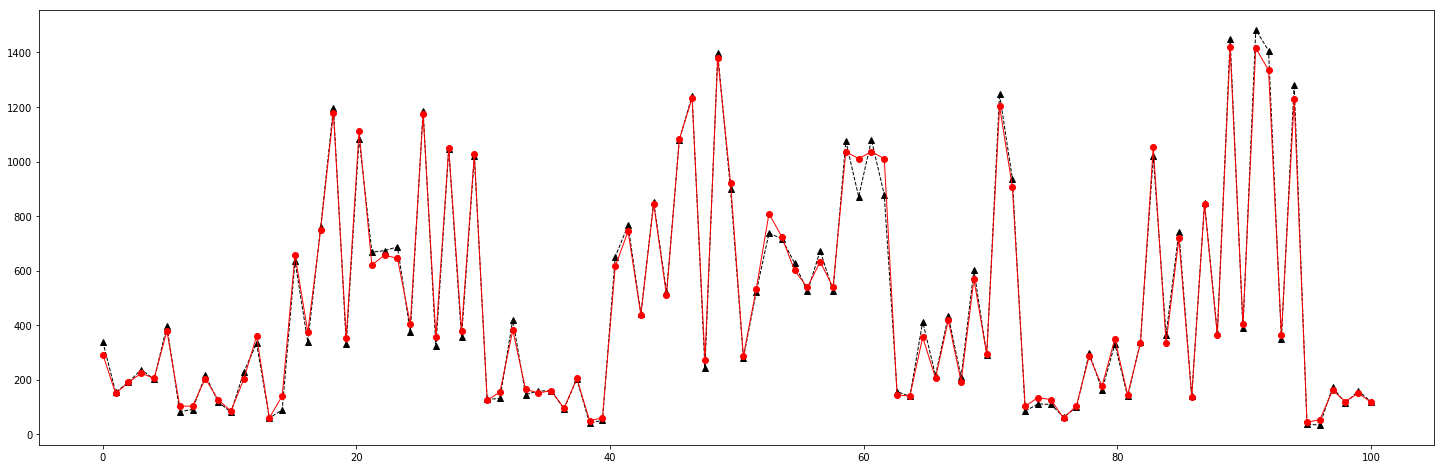

In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt

y = y_true.reshape(-1,)[1600:1700]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[1600:1700]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 8))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

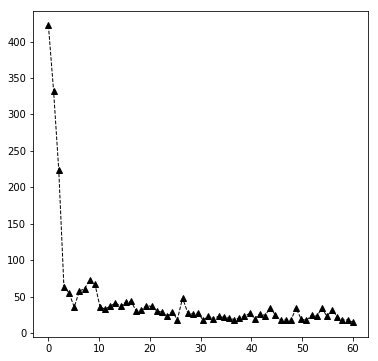

In [34]:
yi = l2_validation
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(xi, yi, 'k^--', linewidth=1, markersize=6)
plt.show()

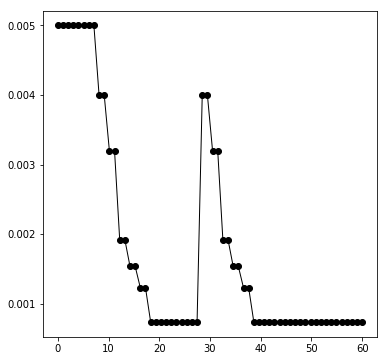

In [35]:
y = lr_step
x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(x, y, 'ko-', linewidth=1, markersize=6)

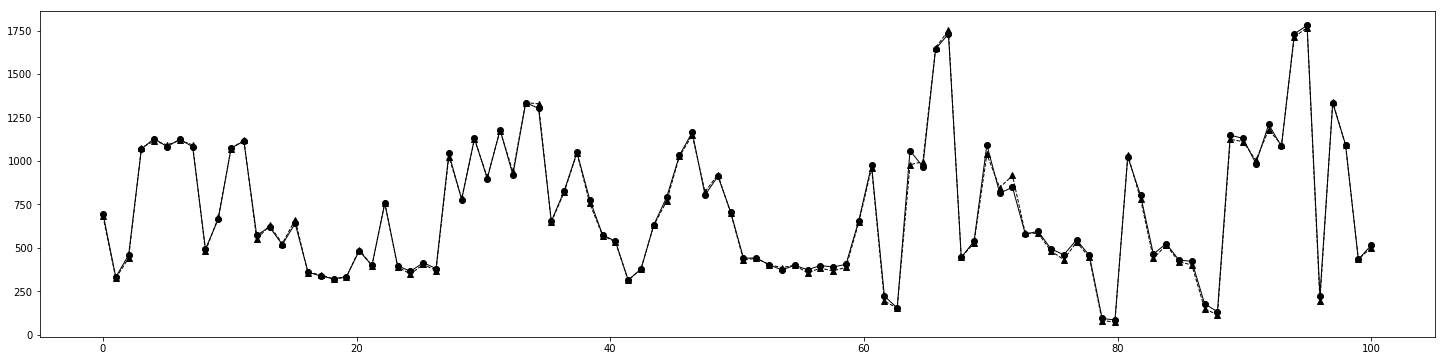

In [37]:
y = y_true.reshape(-1,)[3600:3700]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[3600:3700]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ko-',linewidth=1, markersize=6)
plt.show()

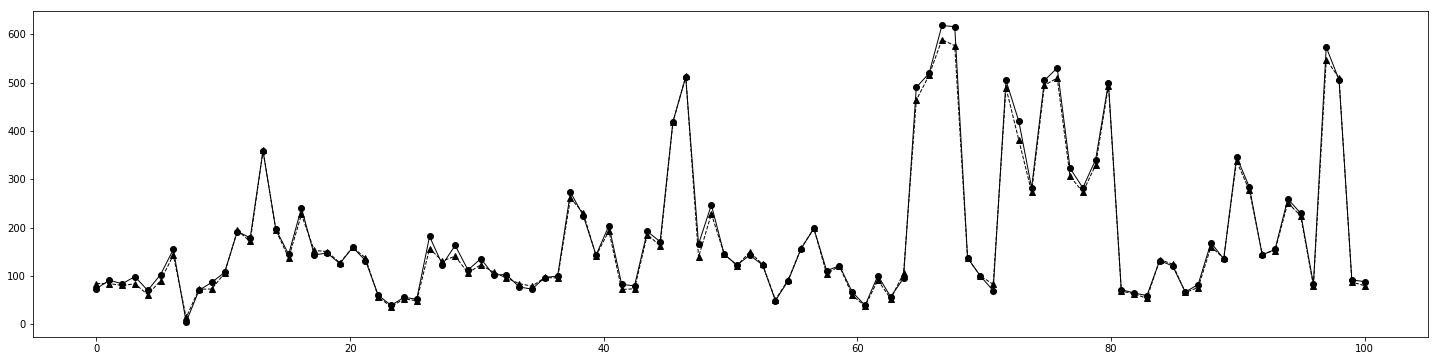

In [39]:
start_time = 0
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ko-',linewidth=1, markersize=6)
plt.show()

In [40]:
y_pred

array([[[[  84.34719  ],
         [  84.5836   ],
         [  80.60039  ],
         ...,
         [ 106.55701  ],
         [ 123.33743  ],
         [ 107.944214 ]],

        [[  96.138626 ],
         [  84.37453  ],
         [  79.01503  ],
         ...,
         [  91.65277  ],
         [  53.073635 ],
         [ 105.37674  ]],

        [[ 463.95657  ],
         [ 516.0225   ],
         [ 588.93933  ],
         ...,
         [ 251.7234   ],
         [ 224.78781  ],
         [  79.97716  ]],

        ...,

        [[ 126.53128  ],
         [ 218.45119  ],
         [ 162.20038  ],
         ...,
         [  69.71527  ],
         [  85.37213  ],
         [  95.22763  ]],

        [[ 320.06207  ],
         [ 377.57205  ],
         [ 345.99686  ],
         ...,
         [  63.094185 ],
         [  86.305916 ],
         [  94.360855 ]],

        [[ 216.04004  ],
         [ 292.19907  ],
         [ 394.0171   ],
         ...,
         [  80.744156 ],
         [  57.03528  ],
         [  37.89

In [23]:
y_true

array([[[[  74.  ],
         [  91.5 ],
         [  84.  ],
         ...,
         [ 112.5 ],
         [ 136.  ],
         [ 102.25]],

        [[ 103.  ],
         [  77.38],
         [  73.  ],
         ...,
         [ 101.  ],
         [  57.  ],
         [  95.34]],

        [[ 490.5 ],
         [ 519.5 ],
         [ 618.5 ],
         ...,
         [ 259.63],
         [ 230.13],
         [  83.38]],

        ...,

        [[ 131.  ],
         [ 204.  ],
         [ 180.5 ],
         ...,
         [  60.5 ],
         [  81.  ],
         [ 104.  ]],

        [[ 343.  ],
         [ 376.  ],
         [ 359.5 ],
         ...,
         [  72.  ],
         [  81.  ],
         [ 104.  ]],

        [[ 196.25],
         [ 269.  ],
         [ 415.  ],
         ...,
         [  85.75],
         [  65.  ],
         [  40.  ]]],


       [[[  70.5 ],
         [ 117.88],
         [ 115.5 ],
         ...,
         [ 130.5 ],
         [  60.5 ],
         [ 102.75]],

        [[  34.5 ],
         [  